In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16

In [2]:
conv_base = VGG16(weights = 'imagenet',
                    include_top=False,
                    input_shape = (150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Feature Extraction without Data Augumentation

In [4]:
import os, shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/cats_and_dogs_small.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [7]:
len(os.listdir('/tmp/cats_and_dogs_small/'))

3

In [8]:
base_data = '/tmp/cats_and_dogs_small/'

train_data = os.path.join(base_data, 'train')

test_data = os.path.join(base_data, 'test')

validation_data = os.path.join(base_data, 'validation')

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [10]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size = (150, 150), 
        batch_size = batch_size, 
        class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i +1) * batch_size] = features_batch
        labels[i * batch_size : (i +1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels   

In [11]:
train_features, train_labels = extract_features(train_data, 2000)

validation_features, validation_labels = extract_features(validation_data, 1000) 

test_features, test_labels = extract_features(test_data,  1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 24ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 25ms/step


In [12]:
train_features = np.reshape(train_features, (2000,  4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [14]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss = 'binary_crossentropy',
              metrics=['acc'])
          
history = model.fit(train_features, train_labels,
                              epochs = 30,
                              batch_size = 20,
                              validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.5766 - acc: 0.6890 - val_loss: 0.4325 - val_acc: 0.8550
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4270 - acc: 0.8075 - val_loss: 0.3634 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3397 - acc: 0.8655 - val_loss: 0.3164 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2979 - acc: 0.8800 - val_loss: 0.2934 - val_acc: 0.8920
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2798 - acc: 0.8900 - val_loss: 0.2830 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2613 - acc: 0.8885 - val_loss: 0.2713 - val_acc: 0.8980
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2462 - acc: 0.9015 - val_loss: 0.2633 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

In [15]:
import matplotlib.pyplot as plt

accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

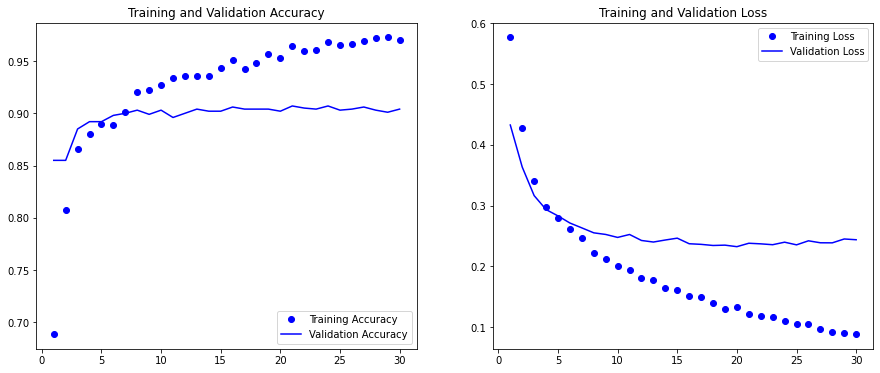

In [16]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

## Feature Extraction with Data Augumentation

In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
          
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [18]:
print('This is the nunber of trainable weights '
     'before freezing the conv base:', len(model.trainable_weights))

This is the nunber of trainable weights before freezing the conv base: 30


In [19]:
conv_base.trainable = False

print('This is the nunber of trainable weights '
     'after freezing the conv base:', len(model.trainable_weights))

This is the nunber of trainable weights after freezing the conv base: 4


In [20]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range= 0.2, 
    zoom_range= 0.2, 
    horizontal_flip = True, 
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(
    train_data, 
    target_size = (150, 150), 
    batch_size= 20, 
    class_mode= 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data, 
    target_size = (150, 150), 
    batch_size= 20, 
    class_mode= 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model.compile(loss = 'binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
    train_generator, 
    steps_per_epoch = 100,
    epochs = 30, 
    validation_data = validation_generator, 
    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 18s 176ms/step - loss: 0.6121 - acc: 0.6680 - val_loss: 0.4490 - val_acc: 0.8350
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - loss: 0.4905 - acc: 0.7690 - val_loss: 0.3675 - val_acc: 0.8440
Epoch 3/30
100/100 [==============================] - 17s 174ms/step - loss: 0.4364 - acc: 0.8125 - val_loss: 0.3333 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 17s 174ms/step - loss: 0.4123 - acc: 0.8210 - val_loss: 0.3083 - val_acc: 0.8700
Epoch 5/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3851 - acc: 0.8315 - val_loss: 0.2926 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3743 - acc: 0.8380 - val_loss: 0.2814 - val_acc: 0.8830
Epoch 7/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3628 - acc: 0.8360 - val_loss: 0.2759 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 1

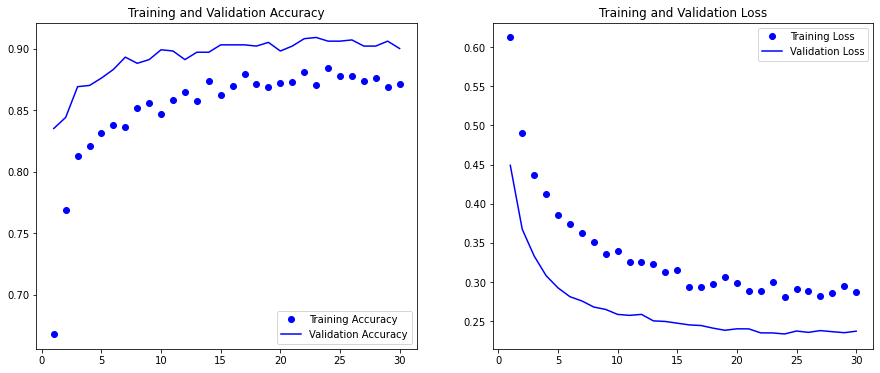

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)


plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

# Fine Tuning

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [24]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(loss = 'binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
    train_generator, 
    steps_per_epoch = 100,
    epochs = 100, 
    validation_data = validation_generator, 
    validation_steps = 50,)

Epoch 1/100
100/100 [==============================] - 19s 175ms/step - loss: 0.3144 - acc: 0.8630 - val_loss: 0.2629 - val_acc: 0.8860
Epoch 2/100
100/100 [==============================] - 17s 175ms/step - loss: 0.2665 - acc: 0.8895 - val_loss: 0.2038 - val_acc: 0.9210
Epoch 3/100
100/100 [==============================] - 17s 174ms/step - loss: 0.2342 - acc: 0.9015 - val_loss: 0.2382 - val_acc: 0.9060
Epoch 4/100
100/100 [==============================] - 17s 174ms/step - loss: 0.2259 - acc: 0.9050 - val_loss: 0.1933 - val_acc: 0.9300
Epoch 5/100
100/100 [==============================] - 17s 174ms/step - loss: 0.1974 - acc: 0.9145 - val_loss: 0.1856 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 17s 173ms/step - loss: 0.1827 - acc: 0.9250 - val_loss: 0.1850 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 17s 174ms/step - loss: 0.1449 - acc: 0.9365 - val_loss: 0.2797 - val_acc: 0.9020
Epoch 8/100
100/100 [===========================

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

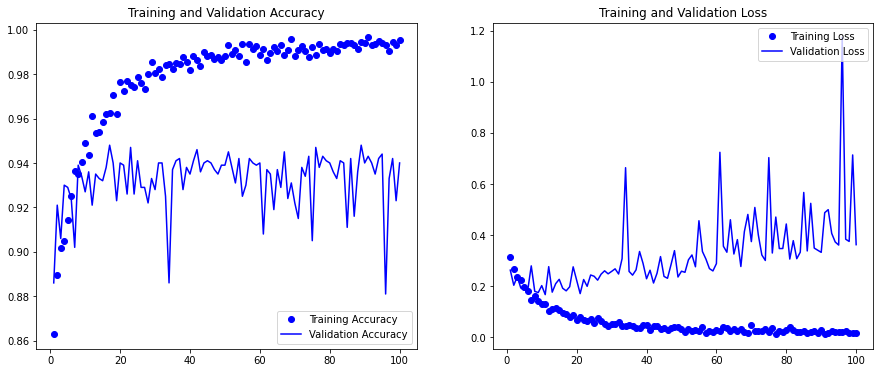

In [27]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

## Smoothing the plot

In [28]:
def smooth_curve(points, factor =0.9):
    smoothed_points = []  
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))

        else:
            smoothed_points.append(point)

    return smoothed_points

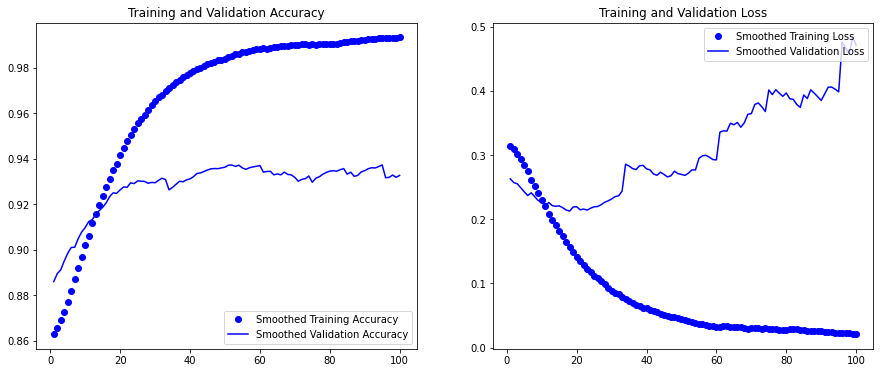

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed Training Accuracy')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

In [30]:
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')


test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print('test accuracy:', test_acc*100)
print('test loss:', test_loss*100)

Found 1000 images belonging to 2 classes.


<ipython-input-30-5b196db3ddb8>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)


test accuracy: 93.90000104904175
test loss: 38.65352272987366
